[Notebook of task](https://github.com/DistributedSystemsGroup/Algorithmic-Machine-Learning/blob/master/Challenges/Plankton/plankton_challenge.ipynb)

# Useful websites and articles
- [Data augmentation part 1](https://medium.com/nanonets/nanonets-how-to-use-deep-learning-when-you-have-limited-data-f68c0b512cab)
- [Data augmentation part 2](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)

### Libraries for Deep NNs
Most relevant
- [TensorFlow](https://www.tensorflow.org/)
- [Keras](https://keras.io/)
- [Theano](http://deeplearning.net/software/theano/)

Less relevant (mostly for GPU optimisation)
- [Caffe](http://caffe.berkeleyvision.org/)
- [Neon](https://www.intel.ai/neon-2-0-optimized-for-intel-architectures/)


# Gjenstående oppgaver

- Generere mer data, for å gjevne ut dataset 
- Lage funksjon for å laste bilder inn i minne, uten å fylle det opp
- Teste ut forskjellige CNN arkitekturer
 - input -> (conv -> pool)*2 -> fc -> softmax
 - input -> (conv -> conv -> pool)*3-4 -> fc -> fc -> softmax
- Lage feature recognition model
- Data exploration

In [1]:
%matplotlib inline
# For configuration and jupiter
import os
import sys
import re
import random
import matplotlib
import implicit
import warnings
# For data manipulation
import pandas as pd
import numpy as np
# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
# For prediction
from tqdm import tqdm

# code inspired by https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/
import zipfile
from extract_zip import extract_zip_to_memory # function for decompressing zip in memory
from PIL import Image, ImageOps # image handling
from io import BytesIO # image handling

base = '/mnt/datasets/plankton/flowcam/'

# Nr of picture/rows = 243 611

In [2]:
# Extract images
imgFiles = extract_zip_to_memory(base + "imgs.zip")

100%|██████████| 243611/243611 [00:22<00:00, 10984.14it/s]


In [3]:
# Extract labels
labelsDF = pd.read_csv(base + 'meta.csv')

In [23]:
#print(imgFiles['imgs/32738710.jpg']) # How to fetch one image
#print(list(imgFiles.keys())[:5]) # How to fetch image keys
#print(np.array(Image.open(imgFiles['imgs/32738710.jpg']))) # How to fetch image as numpy array
#Image.open(imgFiles['imgs/32627324.jpg']) # How to open image only. This shows the actual image if it is in its own cell

In [4]:
print(labelsDF.isnull().sum().any())

True


In [5]:
labelsDF['objid'] = labelsDF['objid'].astype(np.int64, errors='ignore')
labelsDF['level1'] = labelsDF['level1'].fillna('No_level1_name')
labelsDF['level2'] = labelsDF['level2'].fillna('No_level2_name')

print(labelsDF.isnull().sum().any())

False


In [6]:
print('Nr. of unique level1 names:', labelsDF['level1'].nunique())
print('Nr. of unique level2 names:', labelsDF['level2'].nunique())
print('Nr. of unique names  total:', labelsDF['unique_name'].nunique())

Nr. of unique level1 names: 57
Nr. of unique level2 names: 40
Nr. of unique names  total: 103


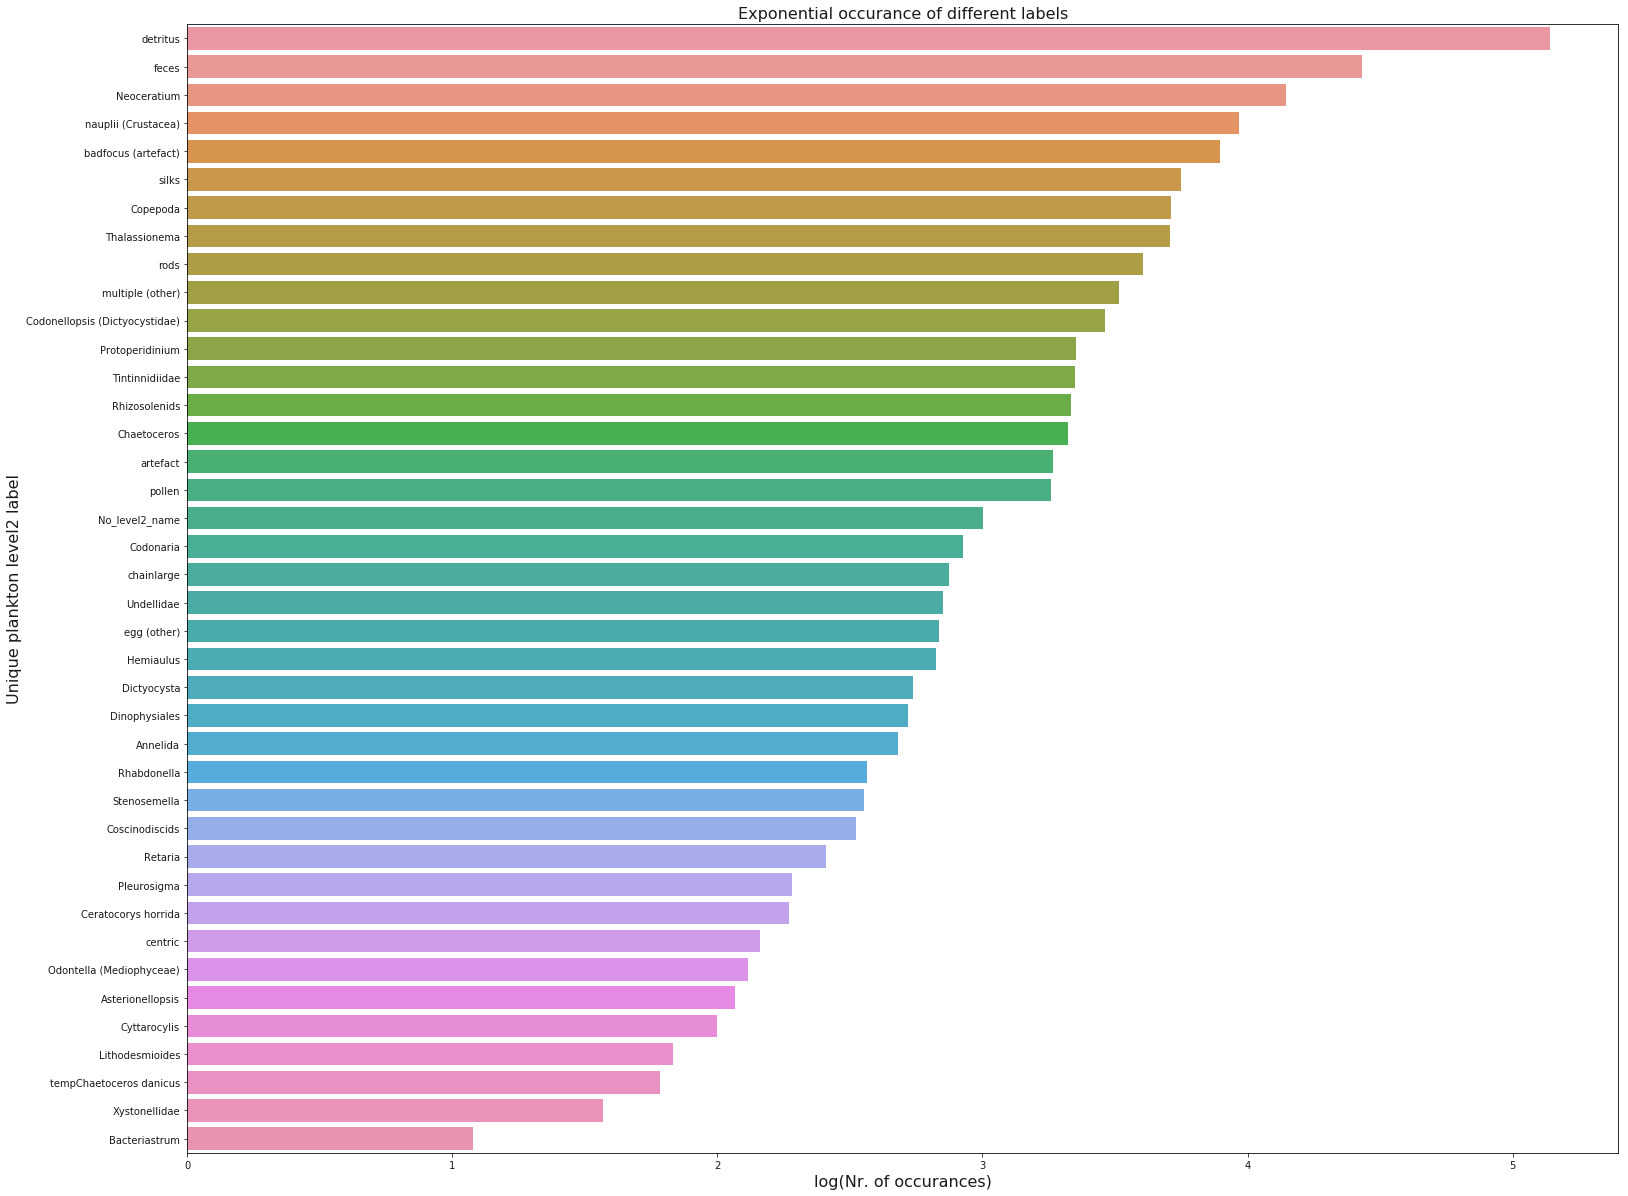

In [7]:
number_unique_names = labelsDF.groupby('level2', as_index=True)['id'].count()
number_unique_names.sort_values(inplace=True, ascending=False)

figure, ax = plt.subplots(figsize=(23,17))
ax = sns.barplot(y=number_unique_names.index, x=np.log10(number_unique_names.values))
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

sns.set(font_scale=1.6)

plt.ylabel('Unique plankton level2 label', fontsize= 16)
plt.xlabel('log(Nr. of occurances)', fontsize= 16)
plt.title('Exponential occurance of different labels', fontsize=16)
plt.tight_layout()

In [8]:
# Fetching the object ids that pertain to specific labels
unique_names = list(number_unique_names.index)
original_objid_dict = {}
# Fetching the level2 labels of the categories we want to duplicate
labels_to_multiply = []
labels_not_to_multiply = []

for name in unique_names:
    objid_labels = list(labelsDF.loc[labelsDF['level2'] == name, 'objid'])
    original_objid_dict.update({name : objid_labels})
    #print('Label:', name[:4], 'has', len(objid_labels), 'object IDs.')
    # Find labels that we want to generate more data within
    if len(objid_labels) < 1000:
        labels_to_multiply.append(name)
    else:
        labels_not_to_multiply.append(name)

In [9]:
def strip(key):
    return int(key[5:-4])

def key_to_objid(list_of_keys):
    return [strip(key) for key in list_of_keys]

def reverse_strip(objid):
    return 'imgs/' + str(objid) + '.jpg'

def objid_to_key(list_of_objids):
    return [reverse_strip(objid) for objid in list_of_objids]

def fetch_label(key, lvl='level2'):
    return list(labelsDF[labelsDF['objid']==strip(key)][lvl])[0]

# Functions to preprocess images
def image_processing(key, final_size=(32, 32)):
    desired_size = 972 # max of width and height in dataset
    im_orginal = Image.open(imgFiles[key])
    old_size = im_orginal.size  # old_size[0] is in (width, height) format
    
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im_scaled = im_orginal.resize(new_size) # scale up picture before padding to keep information
    
    delta_w = desired_size - new_size[0]
    delta_h = desired_size - new_size[1]
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    im_padded = ImageOps.expand(im_scaled, padding, fill=255) # padding of scaled picture
    
    im_final = im_padded.resize(final_size, resample=0) # resize to input size of CNN
    return np.array(im_final)

def image_processing_keep_relative_size(key):
    return 0

In [10]:
img_keys = list(imgFiles.keys())
processed_imgs = {strip(key) : [image_processing(key), fetch_label(key)] for key in tqdm(img_keys)}

100%|██████████| 243610/243610 [07:28<00:00, 543.15it/s]


In [11]:
del imgFiles

In [12]:
def generate_new_object_ids(object_id):
    stripped_key = str(object_id)
    key_lr = int('8' + stripped_key[1:])
    key_ud = int('1' + stripped_key[1:])
    key_90 = int('2' + stripped_key[1:])
    key_180 = int('4' + stripped_key[1:])
    key_270 = int('5' + stripped_key[1:])
    key_t1 = int('6' + stripped_key[1:])
    key_t2 = int('7' + stripped_key[1:])
    return {'lr' : key_lr, 'ud' : key_ud, '90' : key_90, '180' : key_180,
                '270' : key_270, 't1' : key_t1, 't2' : key_t2}

def generate_duplicates_numpy(object_id, image_files=processed_imgs):
    # Fetching and making numpy array of original object
    img_np_array = image_files[object_id][0]

    # Generating copies of data using numpy functions for flipping, rotating and transposing
    img_flipped_ud = np.flip(img_np_array, 0)
    img_flipped_lr = np.flip(img_np_array, 1)
    img_rot_90 = np.rot90(img_np_array, k=1)
    img_rot_180 = np.rot90(img_np_array, k=2)
    img_rot_270 = np.rot90(img_np_array, k=3)
    img_tran_1 = np.transpose(img_np_array)
    img_tran_2 = np.flip(np.transpose(np.flip(img_np_array, 1)), 1)
    
    # Generating new keys
    key_dict = generate_new_object_ids(object_id)
    # Fetching label
    lbl = fetch_label(reverse_strip(object_id))
    # Updating dictionary of images with new data
    image_files.update({key_dict['ud'] : [img_flipped_ud, lbl], key_dict['lr'] : [img_flipped_lr, lbl], 
                      key_dict['90'] : [img_rot_90, lbl], key_dict['180'] : [img_rot_180, lbl], 
                      key_dict['270'] : [img_rot_270, lbl], key_dict['t1'] : [img_tran_1, lbl], 
                      key_dict['t2'] : [img_tran_2, lbl]})
    
    return image_files

# Maybe worth checking out for keras data generation later 
# https://medium.com/@ksusorokina/image-classification-with-convolutional-neural-networks-496815db12a8

In [13]:
def augment_dataset(image_files=processed_imgs):
    # To keep track of total amount of images created
    total_nr = 0
    # We make a new dictionary to keep track of the augmented data, in relation to the original data
    augmented_objid_dict = {}

    for label in tqdm(labels_to_multiply):
        # Fetch object IDs pertaining to one specific label
        object_ids = original_objid_dict[label]

        #print('For label:', label[:4], 'we generate', len(object_ids)*8, 'new images')
        total_nr += len(object_ids)*8

         # Create a list of the object IDs of the newly created images so we can feed them into augmented_objid_dict
        object_ids_new = []

        # Create new data
        for objid in object_ids:
            image_files = generate_duplicates_numpy(objid)
            object_ids_new += list(generate_new_object_ids(objid).values())

        # Append new object IDs to augmented_objid_dict
        augmented_objid_dict.update({label : object_ids + object_ids_new})

    for label in labels_not_to_multiply:
        augmented_objid_dict.update({label : original_objid_dict[label]})
    
    print('Total nr of new images produced:', total_nr)
    print('new length of images:', len(list(processed_imgs.keys())))
    return image_files, augmented_objid_dict

processed_imgs, augmented_objid_dict = augment_dataset()
nr_keys_in_augmented = 0
for label in list(augmented_objid_dict.keys()):
    nr_keys_in_augmented += len(augmented_objid_dict[label])

print('Number of object ids in augmented:', nr_keys_in_augmented)

100%|██████████| 22/22 [00:07<00:00,  9.04it/s]

Total nr of new images produced: 60632
new length of images: 296663
Number of keys in augmented: 296663


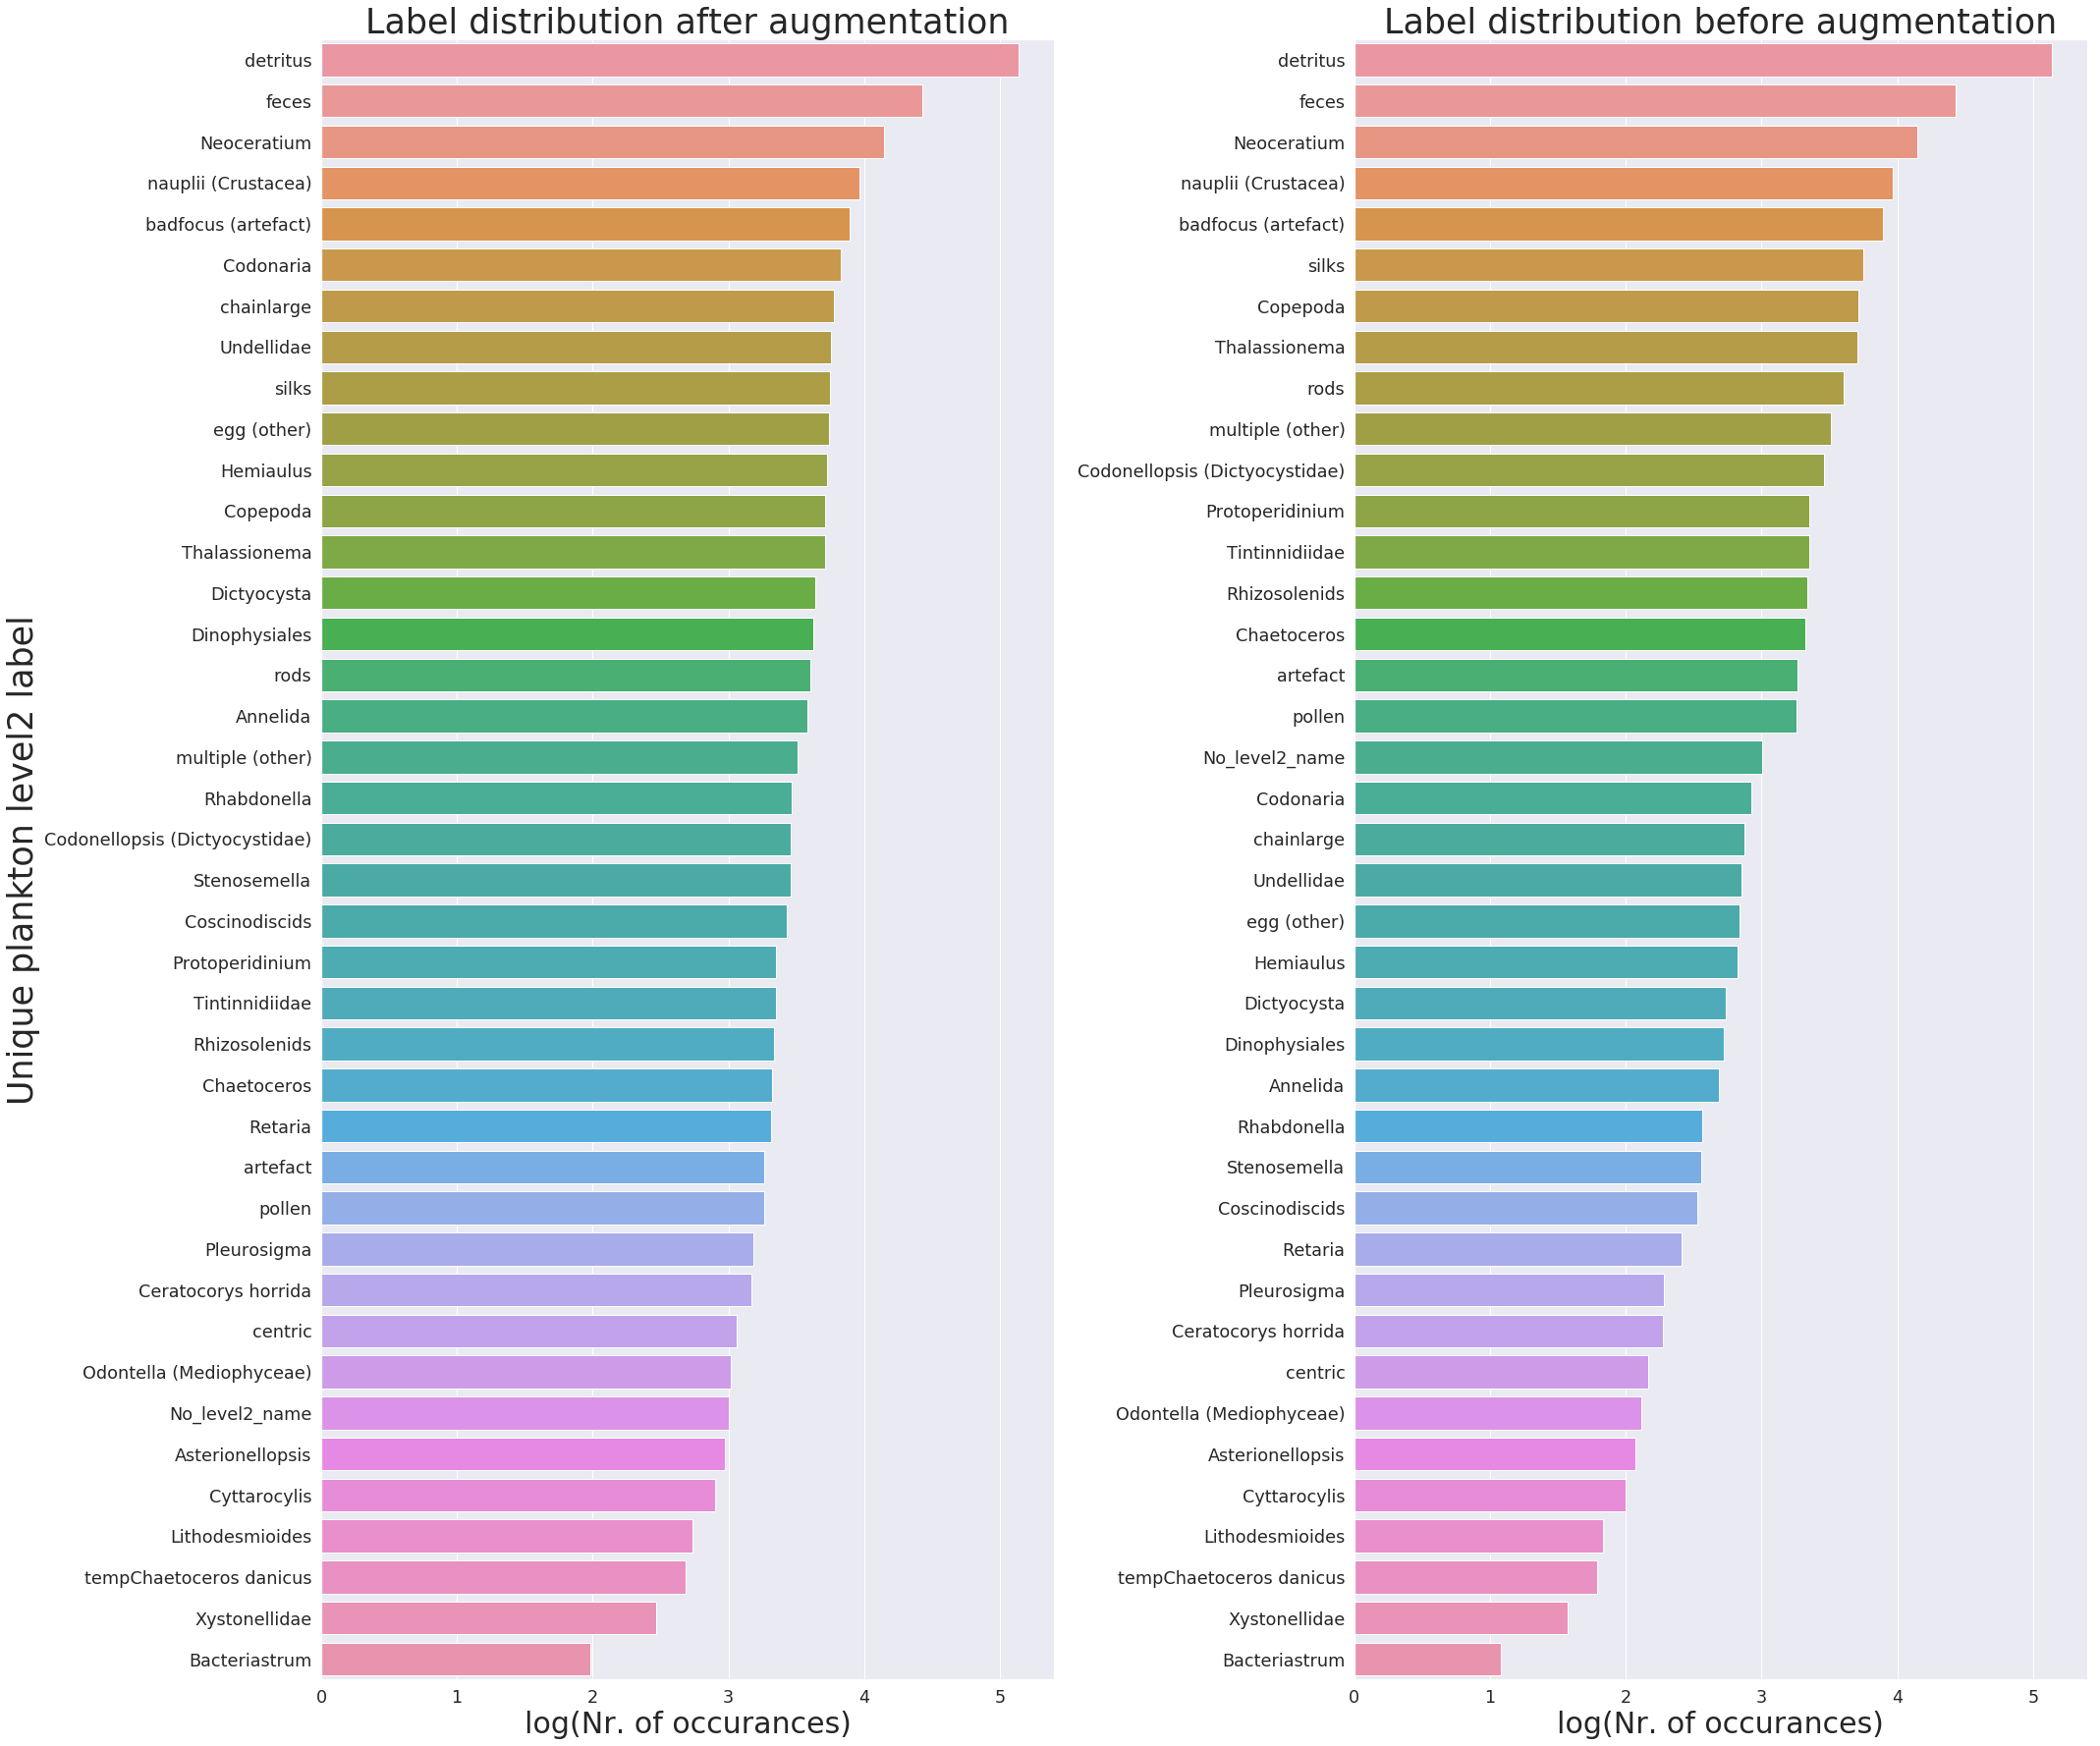

In [14]:
list_labels = []
for objid in list(processed_imgs.keys()):
    list_labels.append([objid, processed_imgs[objid][1]])

labels_objid_dict = {'objid' : [element[0] for element in list_labels],
                     'label' : [element[1] for element in list_labels]}
labelDF = pd.DataFrame.from_dict(labels_objid_dict)

number_unique_names2 = labelDF.groupby('label', as_index=True)['objid'].count()
number_unique_names2.sort_values(inplace=True, ascending=False)

fig = plt.figure(figsize=(30,25))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

sns.barplot(y=number_unique_names2.index, x=np.log10(number_unique_names2.values), ax=ax1)
sns.barplot(y=number_unique_names.index, x=np.log10(number_unique_names.values), ax=ax2)
#ax2.set(yticks=[])
sns.set(font_scale=1.4)

ax1.set_ylabel('Unique plankton level2 label', fontsize=35)
ax1.set_xlabel('log(Nr. of occurances)', fontsize=30)
ax1.set_title('Label distribution after augmentation', fontsize=35)

ax2.set_ylabel('')
ax2.set_xlabel('log(Nr. of occurances)', fontsize=30)
ax2.set_title('Label distribution before augmentation', fontsize=35)
plt.tight_layout()

In [54]:
# Function to split object IDs into training, validation and test datasets
def train_test_val_split(img_dict, train_size=0.6, test_size=0.2):
    train_objids = []
    test_objids = [] 
    val_objids = []
    for label in unique_names:
        object_ids = img_dict[label]
        number_train = int(len(object_ids)*train_size)
        number_test = int(len(object_ids)*test_size)
        train_objids += object_ids[:number_train]
        test_objids += object_ids[number_train:(number_train + number_test)]
        val_objids += object_ids[(number_train + number_test):]
    
    train_objids = random.sample(train_objids, len(train_objids))
    test_objids = random.sample(test_objids, len(test_objids))
    val_objids = random.sample(val_objids, len(val_objids))
    return train_objids, test_objids, val_objids

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
# preprocessing found here: https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5

# Function to load actual images given a set of object IDs
def autoloader(list_of_object_ids):
    X = np.array([processed_imgs[object_id][0] for object_id in list_of_object_ids])
    y = np.array([processed_imgs[object_id][1] for object_id in list_of_object_ids])
    
    # label encode target column
    le = LabelEncoder()
    y = le.fit_transform(y)
    
    # one-hot encode target column
    y = to_categorical(y)
    
    # Reshape input data to account for images only being greyscale
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    return X, y

In [94]:
train_objids, test_objids, val_objids = train_test_val_split(augmented_objid_dict)
# Fetch pictures and labels, corresponding to keys.
# train
X_train, y_train = autoloader(train_objids)
# validation
X_val, y_val = autoloader(val_objids)
# test
X_test, y_test = autoloader(test_objids)

In [95]:
print('-------Shape Training data-------')
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

print('\n-----Shape Validation data-----')
print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)

print('\n--------Shape Test data--------')
print('X_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)

------Training data------
X_train shape: (177980, 32, 32, 1)
y_train shape: (177980, 40)

-----Validation data-----
X_val shape: (59365, 32, 32, 1)
y_val shape: (59365, 40)

--------Test data--------
X_test shape : (59318, 32, 32, 1)
y_test shape : (59318, 40)


In [28]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [29]:
# Making metric for f1-score
# Found at https://www.kaggle.com/guglielmocamporese/macro-f1-score-keras
import tensorflow as tf
import keras.backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)

    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [102]:
# input dimensions
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
# network parameters 
batch_size = 50
classes = labelsDF.level2.unique()
num_classes = labelsDF.level2.nunique()
epochs = 10 # Further Fine Tuning can be done

In [60]:
model = Sequential()

# add first  layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(30, kernel_size=(3, 3), activation='relu'))

# add flatten layer
model.add(Flatten())

# add dense layer
model.add(Dense(64, activation='tanh'))
# add last layer
model.add(Dense(num_classes, activation='softmax'))

# Summary
model.summary()

# Compile model using accuracy to measure model performance --------------------------------------------------
model.compile(loss='categorical_crossentropy',  optimizer="adam", metrics=['accuracy', f1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 30)        8670      
_________________________________________________________________
flatten_2 (Flatten)          (None, 23520)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                1505344   
_________________________________________________________________
dense_5 (Dense)              (None, 40)                2600      
Total params: 1,516,934
Trainable params: 1,516,934
Non-trainable params: 0
_________________________________________________________________


In [61]:
# Train the model --------------------------------------------------------------------------------------------
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val))

# Test the model ---------------------------------------------------------------------------------------------
y_prediction = model.predict(X_test)
f1_score = f1(y_test, y_prediction)
print("F1 Score: ", K.get_value(f1_score))

Train on 146151 samples, validate on 48751 samples
Epoch 1/1
146151/146151 [==============================] - 165s 1ms/step - loss: 1.8655 - acc: 0.5682 - f1: 0.0180 - val_loss: 1.8584 - val_acc: 0.5680 - val_f1: 0.0180
F1 Score:  0.018120948


In [103]:
del model1
K.clear_session()

model1 = Sequential()

# add first  layer
model1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model1.add(Conv2D(30, kernel_size=(3, 3), activation='relu'))
model1.add(Conv2D(3, kernel_size=(2, 2), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.1))

# add flatten layer
model1.add(Flatten())

# add dense layer
model1.add(Dense(150, activation='relu'))
model1.add(Dense(50, activation='relu')) 
model1.add(Dropout(0.1))
# add last layer
model1.add(Dense(num_classes, activation='softmax'))

# Summary
model1.summary()

# Compile model using accuracy to measure model performance --------------------------------------------------
model1.compile(loss='categorical_crossentropy',  optimizer="adam", metrics=['accuracy', f1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 30)        8670      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 3)         363       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 3)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 3)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 507)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               76200     
__________

In [104]:
# Train the model --------------------------------------------------------------------------------------------
model1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val))

# Test the model ---------------------------------------------------------------------------------------------
y_prediction = model1.predict(X_test)
f1_score = f1(y_test, y_prediction)
print("F1 Score: ", K.get_value(f1_score))

Train on 177980 samples, validate on 59365 samples
Epoch 1/10
177980/177980 [==============================] - 196s 1ms/step - loss: 1.6830 - acc: 0.5450 - f1: 0.0598 - val_loss: 1.3085 - val_acc: 0.6111 - val_f1: 0.0935
Epoch 2/10
177980/177980 [==============================] - 194s 1ms/step - loss: 1.2821 - acc: 0.6151 - f1: 0.1102 - val_loss: 1.1500 - val_acc: 0.6581 - val_f1: 0.1311
Epoch 3/10
177980/177980 [==============================] - 194s 1ms/step - loss: 1.1534 - acc: 0.6491 - f1: 0.1405 - val_loss: 1.0773 - val_acc: 0.6772 - val_f1: 0.1551
Epoch 4/10
177980/177980 [==============================] - 196s 1ms/step - loss: 1.0761 - acc: 0.6683 - f1: 0.1572 - val_loss: 1.0500 - val_acc: 0.6834 - val_f1: 0.1585
Epoch 5/10
177980/177980 [==============================] - 196s 1ms/step - loss: 1.0336 - acc: 0.6793 - f1: 0.1676 - val_loss: 1.0023 - val_acc: 0.6978 - val_f1: 0.1728
Epoch 6/10
177980/177980 [==============================] - 196s 1ms/step - loss: 1.0014 - acc: 0.6

In [105]:
from keras.models import load_model

model1.save('my_model_f1_38_augmented_using_10_epochs.h5')  # creates a HDF5 file 'my_model.h5'
# del model1  # deletes the existing model

# returns a compiled model
# identical to the previous one
# model = load_model('my_model.h5')

In [53]:
# Keras CNN model 3: input -> conv(32) -> pool(2,2) -> conv(64) -> pool(2,2) -> dropout(0.25) -> flatten -> fc(64) -> dropout(0.1) -> fc(40) -> softmax

# Create model------------------------------------------------------------------------------------------------
model3 = Sequential()

# add first  layer
model3.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model3.add(MaxPooling2D(pool_size=(2, 2)))

# add second layer
model3.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Dropout(0.5))

# add flatten layer
model3.add(Flatten())
model3.add(Dense(24, activation='relu'))
model3.add(Dropout(0.25))

# add last layer
model3.add(Dense(num_classes, activation='softmax'))

# Compile model using accuracy to measure model performance --------------------------------------------------
model3.compile(loss='categorical_crossentropy',  optimizer="adam", metrics=['accuracy', f1])

# Summary
#model.summary()

# Train the model --------------------------------------------------------------------------------------------
model3.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val))

Train on 177980 samples, validate on 59365 samples
Epoch 1/1
177980/177980 [==============================] - 69s 389us/step - loss: 2.9278 - acc: 0.4883 - f1: 0.0241 - val_loss: 1.5755 - val_acc: 0.5434 - val_f1: 0.0105


In [52]:
y_prediction = model.predict(X_test)
f1_score = f1(y_test, y_prediction)
print("F1 Score: ", K.get_value(f1_score))

F1 Score:  0.0


In [27]:
# Keras CNN model 5:

model = Sequential()

model.add(Conv2D(100, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# COMPILE
model.compile(loss='categorical_crossentropy',  optimizer='adam', metrics=['accuracy', f1])
# Summary
model.summary()
# Train the model --------------------------------------------------------------------------------------------
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 100)       1000      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 100)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        28832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
__________

In [73]:
# Building the CNN structure 1: input -> conv(128) -> conv(32) -> flatten -> fc(40) -> softmax

'''# input dimensions
input_shape = (100, 100, 1)
# network parameters 
batch_size = 40
classes = labelsDF.level2.unique()
num_classes = labelsDF.level2.nunique()
epochs = 3 # Further Fine Tuning can be done

# Create model---------------------------------------------------------------------------------------------
model1 = Sequential()
# Add layers
model1.add(Conv2D(128, kernel_size=3, activation='relu', input_shape=(100,100,1)))
model1.add(Conv2D(32, kernel_size=3, activation='relu'))
model1.add(Flatten())
model1.add(Dense(num_classes, activation='softmax'))

# Compile model using accuracy to measure model performance -----------------------------------------------
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score])

# Train the model -----------------------------------------------------------------------------------------
model1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, y_test))'''
print('Not using this model')

Not using this model


In [120]:
'''# Keras CNN model 3: input -> conv(32) -> pool(2,2) -> conv(64) -> pool(2,2) -> fc(40) -> softmax

# Create model------------------------------------------------------------------------------------------------
model3 = Sequential()

model3.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten())
model3.add(Dense(64, activation='relu'))

model3.add(Dense(num_classes, activation='softmax'))

# Compile model using accuracy to measure model performance --------------------------------------------------
model3.compile(loss='categorical_crossentropy',  optimizer="adam", metrics=['accuracy'])

# Train the model --------------------------------------------------------------------------------------------
model3.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, y_test))'''

Train on 40000 samples, validate on 4000 samples
Epoch 1/3
40000/40000 [==============================] - 247s 6ms/step - loss: 15.7673 - acc: 0.0218 - val_loss: 15.6829 - val_acc: 0.0270
Epoch 2/3
40000/40000 [==============================] - 247s 6ms/step - loss: 15.7671 - acc: 0.0218 - val_loss: 15.6829 - val_acc: 0.0270
Epoch 3/3
40000/40000 [==============================] - 246s 6ms/step - loss: 15.7671 - acc: 0.0218 - val_loss: 15.6829 - val_acc: 0.0270


In [ ]:
'''# Keras CNN model 4: input -> (conv -> conv -> pool)*3-4 -> fc -> fc -> softmax

# Create model------------------------------------------------------------------------------------------------
model4 = Sequential()

model4.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model4.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model4.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model4.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Flatten())
model4.add(Dense(64, activation='relu'))
model4.add(Dense(num_classes, activation='softmax'))

# Compile model using accuracy to measure model performance --------------------------------------------------
model4.compile(loss='categorical_crossentropy',  optimizer="adam", metrics=['accuracy'])

# Train the model --------------------------------------------------------------------------------------------
model4.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, y_test))'''